In [1]:
import sys
import pickle
import glob
import os
import healpy as hp
import numpy as np
from matplotlib import pyplot as plt
import qubic
from qubic import AnalysisMC as amc
from qubic import QubicSkySim as qss
from pysimulators.interfaces.healpy import HealpixConvolutionGaussianOperator
from qubic import AnalysisMC as amc
from qubic import fibtools as ft

In [3]:
def read_maps_from_dict(map_file,constant_spectral_index=True,nbins_ring=25,compute_ang_noise= False):
    
    map_dict = pickle.load(open(map_file,'rb'))
    
    if constant_spectral_index:
        ncomps_out = map_dict['components_i'].shape[0]
        ncomps_in = map_dict['components'].shape[0]
        npix_tot = map_dict['components_i'].shape[1]
        nstokes = map_dict['components_i'].shape[2]
        comp_in = map_dict['components']
        comp_out = map_dict['components_i']
        residuals = comp_out - comp_in[:ncomps_out,:,:]
        seenpix = map_dict['seenpix']
        coverage = map_dict['coverage']
        
    else:
        ncomps_out = map_dict['components_i'].shape[2]
        ncomps_in = map_dict['components'].shape[2]
        npix_tot = map_dict['components_i'].shape[1]
        nstokes = map_dict['components_i'].shape[0]
        comp_in = map_dict['components'].T
        comp_out = map_dict['components_i'].T
        residuals = comp_out - comp_in[:ncomps_out,:,:]
        seenpix = map_dict['seenpix']
        coverage = map_dict['coverage']
    
    comp_out_qubicpatch = comp_out[:,map_dict['seenpix'],:]
    comp_in_qubicpatch = comp_in[:,map_dict['seenpix'],:]
    residuals_qubicpatch = residuals[:,map_dict['seenpix'],:]

    center = map_dict['center']
    # center_equ = map_dict['center']#[0,-57]
    # center_gal = qubic.equ2gal(center_equ[0], center_equ[1])
    
    nside = hp.npix2nside(npix_tot)
    pixsnum_seenpix = np.where(seenpix)[0]
    centralpix = hp.ang2pix(nside, center[0],center[1],lonlat=True)
    angmax= np.max( qss.get_angles(centralpix,pixsnum_seenpix,nside) )
    
    if compute_ang_noise:
        
        angs_int_dust,I_int_dust,Q_int_dust,U_int_dust,dI_int_dust,dQ_int_dust,dU_int_dust = get_angular_profile(residuals[1,:,:],thmax=angmax,nbins=1,doplot=False,allstokes=True,separate=True,integrated=True,center=center)
        angs_int_cmb,I_int_cmb,Q_int_cmb,U_int_cmb,dI_int_cmb,dQ_int_cmb,dU_int_cmb = get_angular_profile(residuals[0,:,:],thmax=angmax,nbins=1,doplot=False,allstokes=True,separate=True,integrated=True,center=center)

        residuals_angular_circles = np.array([[angs_int_cmb,I_int_cmb,Q_int_cmb,U_int_cmb,dI_int_cmb,dQ_int_cmb,dU_int_cmb],[angs_int_dust,I_int_dust,Q_int_dust,U_int_dust,dI_int_dust,dQ_int_dust,dU_int_dust]])

        angs_dust,I_dust,Q_dust,U_dust,dI_dust,dQ_dust,dU_dust = qss.get_angular_profile(residuals[1,:,:],thmax=30,nbins=nbins_ring,doplot=False,allstokes=True,separate=True,center=center)
        angs_cmb,I_cmb,Q_cmb,U_cmb,dI_cmb,dQ_cmb,dU_cmb = qss.get_angular_profile(residuals[0,:,:],thmax=30,nbins=nbins_ring,doplot=False,allstokes=True,separate=True,center=center)

        residuals_angular_rings = np.array([[angs_cmb,I_cmb,Q_cmb,U_cmb,dI_cmb,dQ_cmb,dU_cmb],[angs_dust,I_dust,Q_dust,U_dust,dI_dust,dQ_dust,dU_dust]])

        invcov_dust,I_dust,Q_dust,U_dust,dI_dust,dQ_dust,dU_dust = qss.get_angular_profile(residuals[1,:,:],thmax=30,nbins=nbins_ring,doplot=False,allstokes=True,separate=True,center=center,withcoverage=True,coverage=coverage)
        invcov_cmb,I_cmb,Q_cmb,U_cmb,dI_cmb,dQ_cmb,dU_cmb = qss.get_angular_profile(residuals[0,:,:],thmax=30,nbins=nbins_ring,doplot=False,allstokes=True,separate=True,center=center,withcoverage=True,coverage=coverage)
        
        residuals_coverage_rings = np.array([[invcov_cmb,I_cmb,Q_cmb,U_cmb,dI_cmb,dQ_cmb,dU_cmb],[invcov_dust,I_dust,Q_dust,U_dust,dI_dust,dQ_dust,dU_dust]])        

        return comp_out_qubicpatch, comp_in_qubicpatch, residuals_qubicpatch, residuals_angular_circles, residuals_angular_rings, residuals_coverage_rings, residuals, seenpix, angmax, nside, center, coverage

    else:
        
        return comp_out, comp_in, residuals, nside, seenpix, angmax, center, coverage        

sys.path.insert(1,"/home/nahue-ofi/CMM-Pipeline/src")
# sys.path.insert(1,"/home/nahue/CMM-Pipeline/src")

from simtools.analysis import get_angular_profile

In [4]:
# map_dict = pickle.load(open('/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_fullHFI_planck_parametric_d0_two/file_seed1_3636555_k153.pkl','rb'))

In [5]:
# print(map_dict.keys())

In [6]:
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_30_44_70_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_100_143_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_217_353_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_fullHFI_planck_parametric_d0_two'
# # # thedir = '/home/nahue-ofi/heavy-data/realistic_in_cmb_d1_s0_out_cmb_d1_parametric_d1_two'
# # # thedir = '/home/nahue-ofi/heavy-data/forecast_inCMBDustSync_outCMBDustSync_advancedparametric_d0_two'

# # # thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_30_44_70_planck_parametric_d0_two'
# # # thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_100_143_planck_parametric_d0_two'
# # # thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_217_353_planck_parametric_d0_two'
# # thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_fullHFI_planck_parametric_d0_two'


# dic_name = '*file*'
# realizations = np.sort(glob.glob(thedir + '/' + dic_name))

# # for i in range(len(realizations)):
# #     print(i, realizations[i])

# # realizations = realizations[:30]

# nreals = len(realizations)

# print(nreals)

In [7]:
# base_dir = '/media/nahue/files_hdd/heavy-data/cmm-results/'
base_dir = '/home/nahue-ofi/heavy-data/'

different_bands = ['cmb_d0_fullHFI_planck_parametric_d0_two']

# different_bands = ['cmb_d0_30_44_70_planck_parametric_d0_two', 'cmb_d0_100_143_planck_parametric_d0_two',
#                     'cmb_d0_217_353_planck_parametric_d0_two', 'cmb_d0_fullHFI_planck_parametric_d0_two']

In [10]:
for j, dif_band in enumerate(different_bands):

    realizations = np.sort(glob.glob(base_dir+dif_band+'/'+'**'))

    nreals = len(realizations)

    print(nreals)
      
    constant_spectral_index = True
    
    nbins_ring = 35

    compute_ang_noise = False

    if compute_ang_noise is True:
        
        angs_cmb = np.zeros((nreals,nbins_ring))
        Q_cmb = np.zeros((nreals,nbins_ring))
        U_cmb = np.zeros((nreals,nbins_ring))
        dQ_cmb = np.zeros((nreals,nbins_ring))
        dU_cmb = np.zeros((nreals,nbins_ring))
        angs_dust = np.zeros((nreals,nbins_ring))
        Q_dust = np.zeros((nreals,nbins_ring))
        U_dust = np.zeros((nreals,nbins_ring))
        dQ_dust = np.zeros((nreals,nbins_ring))
        dU_dust = np.zeros((nreals,nbins_ring))
    
        Q_cmb_int = np.zeros(nreals)
        U_cmb_int = np.zeros(nreals)
        dQ_cmb_int = np.zeros(nreals)
        dU_cmb_int = np.zeros(nreals)
        Q_dust_int = np.zeros(nreals)
        U_dust_int = np.zeros(nreals)
        dQ_dust_int = np.zeros(nreals)
        dU_dust_int = np.zeros(nreals)
    
        invcov_cmb = np.zeros((nreals,nbins_ring))
        Qic_cmb = np.zeros((nreals,nbins_ring))
        Uic_cmb = np.zeros((nreals,nbins_ring))
        dQic_cmb = np.zeros((nreals,nbins_ring))
        dUic_cmb = np.zeros((nreals,nbins_ring))
        invcov_dust = np.zeros((nreals,nbins_ring))
        Qic_dust = np.zeros((nreals,nbins_ring))
        Uic_dust = np.zeros((nreals,nbins_ring))
        dQic_dust = np.zeros((nreals,nbins_ring))
        dUic_dust = np.zeros((nreals,nbins_ring))
    
    for i,map_file in enumerate(realizations[:1]):
        print(i)

        if compute_ang_noise is True:
            
            comp_out_qubicpatch, comp_in_qubicpatch, residuals_qubicpatch, residuals_angular_circles, residuals_angular_rings, residuals_cov_rings, residuals, seenpix, angmax, nside, center, coverage = read_maps_from_dict(map_file,constant_spectral_index=constant_spectral_index,nbins_ring=nbins_ring,compute_ang_noise=compute_ang_noise)
            angs_cmb[i,:] = residuals_angular_rings[0,0]
            Q_cmb[i,:] = residuals_angular_rings[0,2]
            U_cmb[i,:] = residuals_angular_rings[0,3]
            dQ_cmb[i,:] = residuals_angular_rings[0,5]
            dU_cmb[i,:] = residuals_angular_rings[0,6]
            angs_dust[i,:] = residuals_angular_rings[1,0]
            Q_dust[i,:] = residuals_angular_rings[1,2]
            U_dust[i,:] = residuals_angular_rings[1,3]
            dQ_dust[i,:] = residuals_angular_rings[1,5]
            dU_dust[i,:] = residuals_angular_rings[1,6]
    
            Q_cmb_int[i] = residuals_angular_circles[0,2][0]
            U_cmb_int[i] = residuals_angular_circles[0,3][0]
            dQ_cmb_int[i] = residuals_angular_circles[0,5][0]
            dU_cmb_int[i] = residuals_angular_circles[0,6][0]
            Q_dust_int[i] = residuals_angular_circles[1,2][0]
            U_dust_int[i] = residuals_angular_circles[1,3][0]
            dQ_dust_int[i] = residuals_angular_circles[1,5][0]
            dU_dust_int[i] = residuals_angular_circles[1,6][0]
    
            invcov_cmb[i,:] = residuals_cov_rings[0,0]
            Qic_cmb[i,:] = residuals_cov_rings[0,2]
            Uic_cmb[i,:] = residuals_cov_rings[0,3]
            dQic_cmb[i,:] = residuals_cov_rings[0,5]
            dUic_cmb[i,:] = residuals_cov_rings[0,6]
            invcov_dust[i,:] = residuals_cov_rings[1,0]
            Qic_dust[i,:] = residuals_cov_rings[1,2]
            Uic_dust[i,:] = residuals_cov_rings[1,3]
            dQic_dust[i,:] = residuals_cov_rings[1,5]
            dUic_dust[i,:] = residuals_cov_rings[1,6]    

        else:
            
            comp_out, comp_in, residuals, nside, seenpix, angmax, center, coverage = read_maps_from_dict(map_file,constant_spectral_index=constant_spectral_index,nbins_ring=nbins_ring,compute_ang_noise=compute_ang_noise)
    
    results = {}
    # results['angs_cmb'] = angs_cmb
    # results['dQ_cmb'] = dQ_cmb
    # results['dU_cmb'] = dU_cmb
    # results['Q_cmb'] = Q_cmb
    # results['U_cmb'] = U_cmb
    # results['angs_dust'] = angs_dust
    # results['dQ_dust'] = dQ_dust
    # results['dU_dust'] = dU_dust
    # results['Q_dust'] = Q_dust
    # results['U_dust'] = U_dust
    # results['dQ_cmb_int'] = dQ_cmb_int
    # results['dU_cmb_int']= dU_cmb_int
    # results['dQ_dust_int'] = dQ_dust_int
    # results['dU_dust_int'] = dU_dust_int 
    # results['Q_cmb_int'] = Q_cmb_int
    # results['U_cmb_int']= U_cmb_int
    # results['Q_dust_int'] = Q_dust_int
    # results['U_dust_int'] = U_dust_int 
    # results['invocv_cmb'] = invcov_cmb
    # results['dQic_cmb'] = dQic_cmb
    # results['dUic_cmb'] = dUic_cmb
    # results['Qic_cmb'] = Qic_cmb
    # results['Uic_cmb'] = Uic_cmb
    # results['invcov_dust'] = invcov_dust
    # results['dQic_dust'] = dQic_dust
    # results['dUic_dust'] = dUic_dust
    # results['Qic_dust'] = Qic_dust
    # results['Uic_dust'] = Uic_dust
    # results['angmax'] = angmax
    results['coverage'] = coverage
    results['center'] = center
#     results['seenpix'] = seenpix
#     results['residuals'] = res
    
    np.save('coverage_and_center', results)

299
0


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

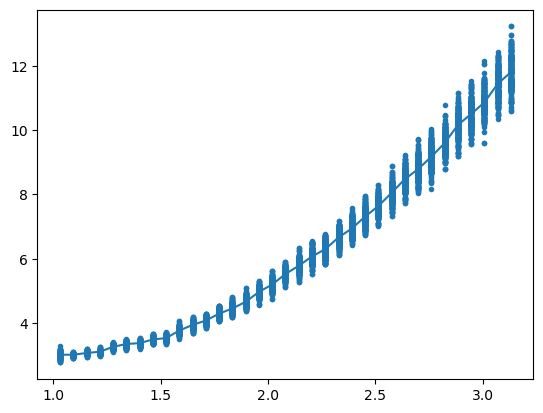

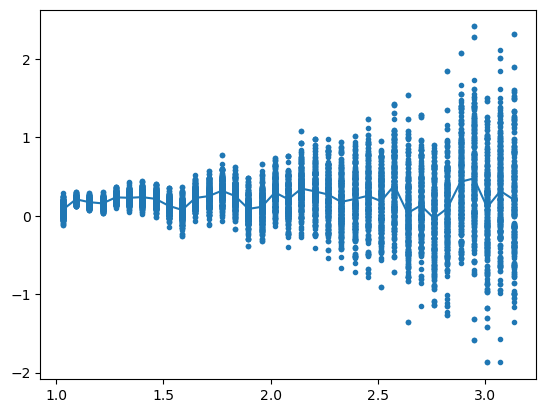

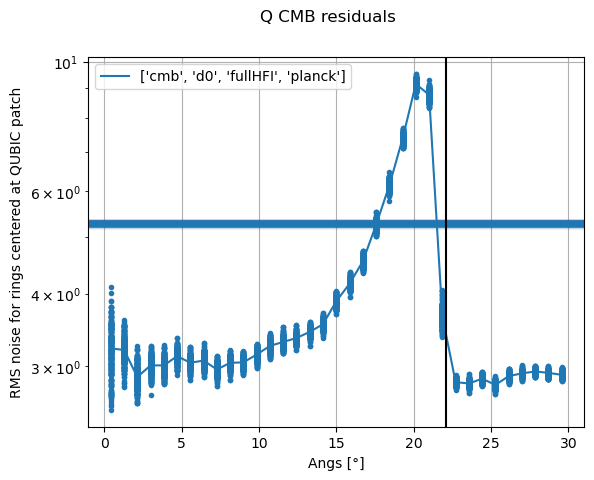

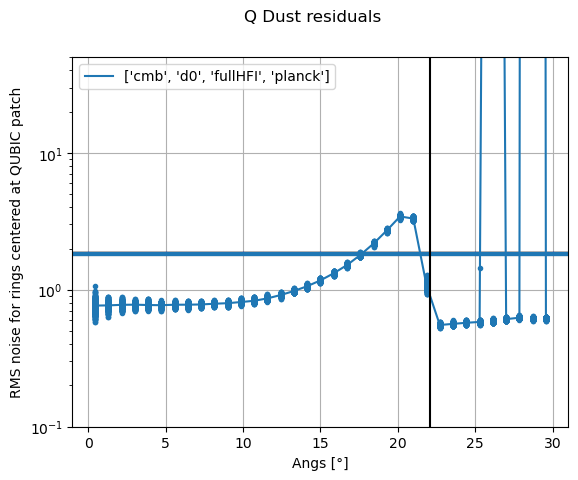

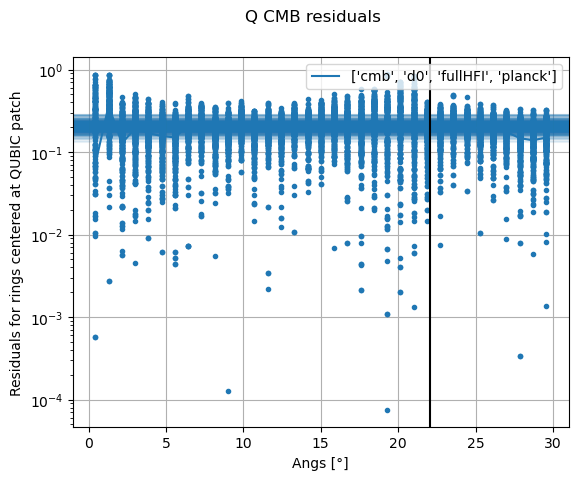

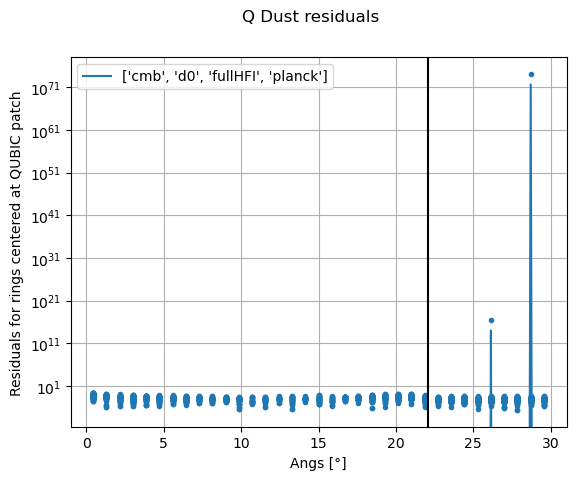

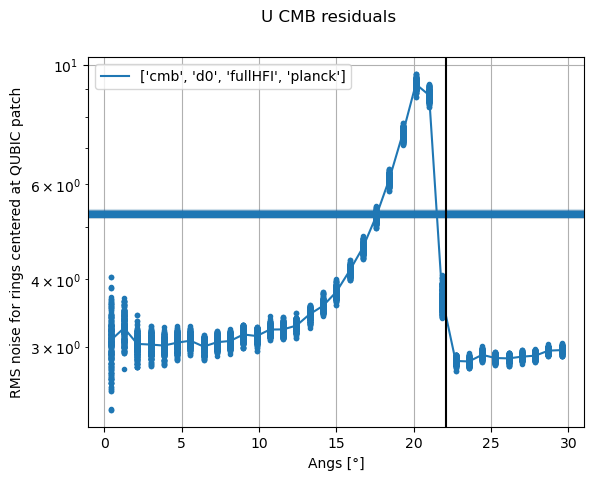

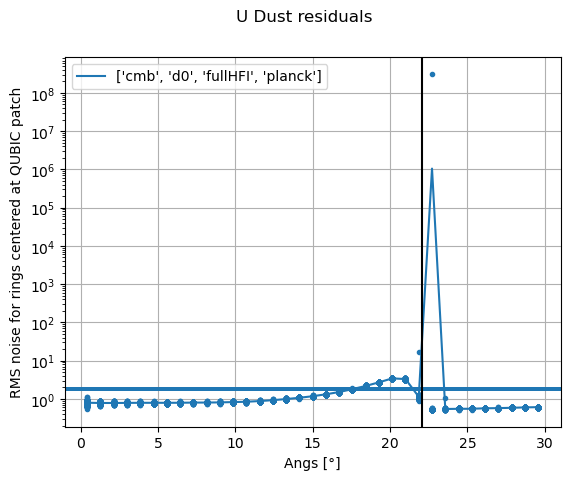

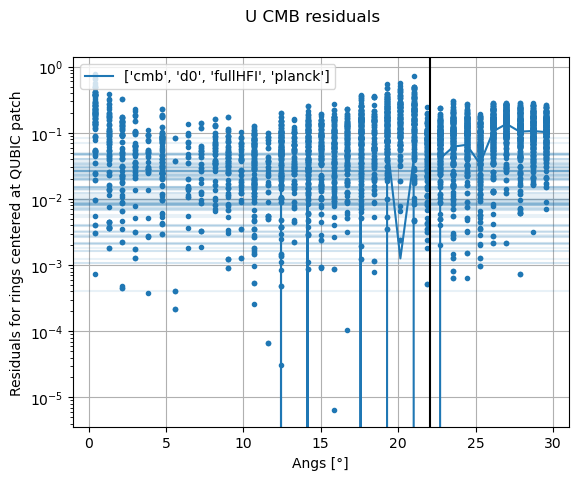

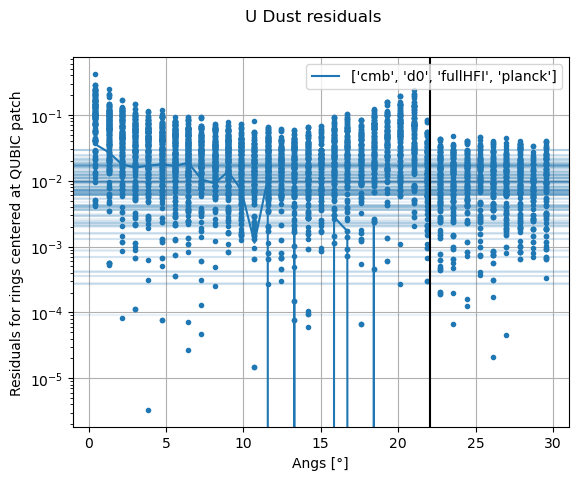

In [5]:
for j, dif_band in enumerate(different_bands):
    
    results_dict = np.load(dif_band+'.npy',allow_pickle=True).item()

    angs_cmb = results_dict['angs_cmb'] 
    dQ_cmb = results_dict['dQ_cmb'] 
    dU_cmb = results_dict['dU_cmb'] 
    Q_cmb = results_dict['Q_cmb'] 
    U_cmb = results_dict['U_cmb'] 
    angs_dust = results_dict['angs_dust'] 
    dQ_dust = results_dict['dQ_dust'] 
    dU_dust = results_dict['dU_dust'] 
    Q_dust = results_dict['Q_dust'] 
    U_dust = results_dict['U_dust'] 
    dQ_cmb_int = results_dict['dQ_cmb_int'] 
    dU_cmb_int = results_dict['dU_cmb_int']
    dQ_dust_int = results_dict['dQ_dust_int'] 
    dU_dust_int = results_dict['dU_dust_int']
    Q_cmb_int = results_dict['Q_cmb_int'] 
    U_cmb_int = results_dict['U_cmb_int']
    Q_dust_int = results_dict['Q_dust_int'] 
    U_dust_int = results_dict['U_dust_int'] 
    angmax = results_dict['angmax']

    invcov_cmb = results_dict['invocv_cmb']
    dQic_cmb = results_dict['dQic_cmb']
    dUic_cmb = results_dict['dUic_cmb']
    Qic_cmb = results_dict['Qic_cmb']
    Uic_cmb = results_dict['Uic_cmb']
    invcov_dust = results_dict['invcov_dust']
    dQic_dust = results_dict['dQic_dust']
    dUic_dust = results_dict['dUic_dust']
    Qic_dust = results_dict['Qic_dust']
    Uic_dust = results_dict['Uic_dust']
    coverage = results_dict['coverage']
    
    plt.figure(0)
    for i in range(len(invcov_cmb[:,0])):
        plt.plot(invcov_cmb[i,:],dQic_cmb[i,:],'.',c=f'C{j}')
    plt.plot(invcov_cmb[0,:],np.mean(dQic_cmb,axis=0),c=f'C{j}',label=dif_band.split('_')[:4])

    plt.figure(10)
    for i in range(len(invcov_cmb[:,0])):
        plt.plot(invcov_cmb[i,:],Qic_cmb[i,:],'.',c=f'C{j}')
    plt.plot(invcov_cmb[0,:],np.mean(Qic_cmb,axis=0),c=f'C{j}',label=dif_band.split('_')[:4])
    
    plt.figure(1)
    for i in range(len(angs_cmb[:,0])):
        plt.plot(angs_cmb[i,:],dQ_cmb[i,:],'.',c=f'C{j}')
        plt.axhline(dQ_cmb_int[i],c=f'C{j}',alpha=0.1)
    plt.plot(angs_cmb[0,:],np.mean(dQ_cmb,axis=0),c=f'C{j}',label=dif_band.split('_')[:4])
    plt.axvline(angmax,c='k')

    plt.figure(2)
    for i in range(len(angs_cmb[:,0])):
        plt.plot(angs_dust[i,:],dQ_dust[i,:],'.',c=f'C{j}')
        plt.axhline(dQ_dust_int[i],c=f'C{j}',alpha=0.1)
    plt.plot(angs_dust[0,:],np.mean(dQ_dust,axis=0),c=f'C{j}',label=dif_band.split('_')[:4])
    plt.axvline(angmax,c='k')

    plt.figure(3)
    for i in range(len(angs_cmb[:,0])):
        plt.plot(angs_cmb[i,:],Q_cmb[i,:],'.',c=f'C{j}')
        plt.axhline(Q_cmb_int[i],c=f'C{j}',alpha=0.1)
    plt.plot(angs_cmb[0,:],np.mean(Q_cmb,axis=0),c=f'C{j}',label=dif_band.split('_')[:4])
    plt.axvline(angmax,c='k')

    plt.figure(4)
    for i in range(len(angs_cmb[:,0])):
        plt.plot(angs_dust[i,:],Q_dust[i,:],'.',c=f'C{j}')
        plt.axhline(Q_dust_int[i],c=f'C{j}',alpha=0.1)
    plt.plot(angs_dust[0,:],np.mean(Q_dust,axis=0),c=f'C{j}',label=dif_band.split('_')[:4])
    plt.axvline(angmax,c='k')
    
    plt.figure(5)
    for i in range(len(angs_cmb[:,0])):
        plt.plot(angs_cmb[i,:],dU_cmb[i,:],'.',c=f'C{j}')
        plt.axhline(dU_cmb_int[i],c=f'C{j}',alpha=0.1)
    plt.plot(angs_cmb[0,:],np.mean(dU_cmb,axis=0),c=f'C{j}',label=dif_band.split('_')[:4])
    plt.axvline(angmax,c='k')

    plt.figure(6)
    for i in range(len(angs_cmb[:,0])):
        plt.plot(angs_dust[i,:],dU_dust[i,:],'.',c=f'C{j}')
        plt.axhline(dU_dust_int[i],c=f'C{j}',alpha=0.1)
    plt.plot(angs_dust[0,:],np.mean(dU_dust,axis=0),c=f'C{j}',label=dif_band.split('_')[:4])
    plt.axvline(angmax,c='k')

    plt.figure(7)
    for i in range(len(angs_cmb[:,0])):
        plt.plot(angs_cmb[i,:],U_cmb[i,:],'.',c=f'C{j}')
        plt.axhline(U_cmb_int[i],c=f'C{j}',alpha=0.1)
    plt.plot(angs_cmb[0,:],np.mean(U_cmb,axis=0),c=f'C{j}',label=dif_band.split('_')[:4])
    plt.axvline(angmax,c='k')

    plt.figure(8)
    for i in range(len(angs_cmb[:,0])):
        plt.plot(angs_dust[i,:],U_dust[i,:],'.',c=f'C{j}')
        plt.axhline(U_dust_int[i],c=f'C{j}',alpha=0.1)
    plt.plot(angs_dust[0,:],np.mean(U_dust,axis=0),c=f'C{j}',label=dif_band.split('_')[:4])
    plt.axvline(angmax,c='k')
    
plt.figure(1)
plt.suptitle('Q CMB residuals')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xlabel('Angs [°]')
plt.ylabel('RMS noise for rings centered at QUBIC patch')
plt.tight_layout

plt.figure(2)
plt.suptitle('Q Dust residuals')
plt.grid()
plt.legend()
plt.ylim(10**(-1),50)
plt.yscale('log')
plt.xlabel('Angs [°]')
plt.ylabel('RMS noise for rings centered at QUBIC patch')
plt.tight_layout

plt.figure(3)
plt.suptitle('Q CMB residuals')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xlabel('Angs [°]')
plt.ylabel('Residuals for rings centered at QUBIC patch')
plt.tight_layout

plt.figure(4)
plt.suptitle('Q Dust residuals')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xlabel('Angs [°]')
plt.ylabel('Residuals for rings centered at QUBIC patch')
plt.tight_layout

plt.figure(5)
plt.suptitle('U CMB residuals')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xlabel('Angs [°]')
plt.ylabel('RMS noise for rings centered at QUBIC patch')
plt.tight_layout

plt.figure(6)
plt.suptitle('U Dust residuals')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xlabel('Angs [°]')
plt.ylabel('RMS noise for rings centered at QUBIC patch')
plt.tight_layout

plt.figure(7)
plt.suptitle('U CMB residuals')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xlabel('Angs [°]')
plt.ylabel('Residuals for rings centered at QUBIC patch')
plt.tight_layout

plt.figure(8)
plt.suptitle('U Dust residuals')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xlabel('Angs [°]')
plt.ylabel('Residuals for rings centered at QUBIC patch')
plt.tight_layout

In [13]:
# qcmb_residuals = residuals[0,:,1]

covcut = 0.1
coverage = coverage / np.max(coverage)
mask_cov = (coverage > covcut)
coverage_masked = np.zeros(len(coverage))
coverage_masked[mask_cov] = coverage[mask_cov]

print(np.sum(coverage_masked)/len(coverage))
1/(0.0145)*(1/15.0)

0.014520573722843336


4.597701149425287

In [ ]:
vec0 = hp.ang2vec(center[0], center[1], lonlat=True)
sh = np.shape(qcmb_residuals)
ns = hp.npix2nside(sh[0])
vecpix = hp.pix2vec(ns, np.arange(12 * ns ** 2))
angs = np.degrees(np.arccos(np.dot(vec0, vecpix)))
# rng = np.array([0, thmax])

# hp.mollview(coverage_masked)
# hp.mollview(1/np.sqrt(coverage_masked))

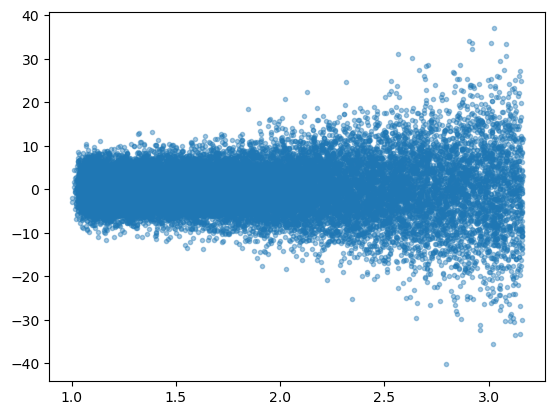

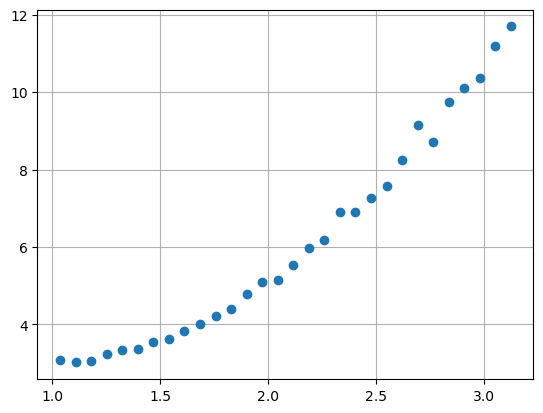

In [81]:
plt.figure()
plt.plot(1/np.sqrt(coverage_masked[mask_cov]), qcmb_residuals[mask_cov],'.',alpha=0.4)

# xx, yyQ, dx, dyQ, _ = ft.profile(np.sqrt(1. / coverage_masked[mask_cov]), qcmb_residuals[mask_cov], nbins=30, plot=False, dispersion = False)
# plt.figure()
# plt.errorbar(xx,yyQ,yerr=dyQ,fmt='o')
# plt.grid()

# plt.figure()
# plt.errorbar(xx,dyQ,fmt='o')
# plt.grid()

xx, yyQ, dx, dyQ, _ = ft.profile(np.sqrt(1. / coverage_masked[mask_cov]), qcmb_residuals[mask_cov], nbins=30, plot=False, dispersion = True)

plt.figure()
plt.errorbar(xx,dyQ,fmt='o')
plt.grid()

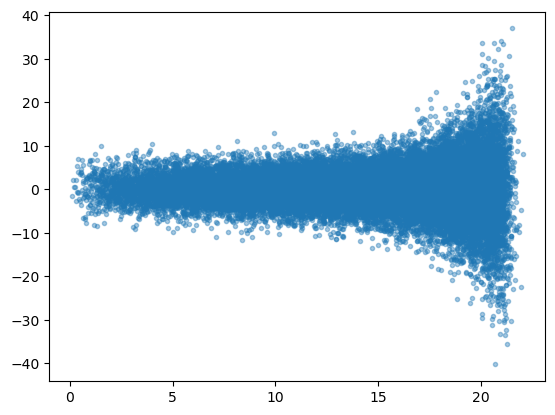

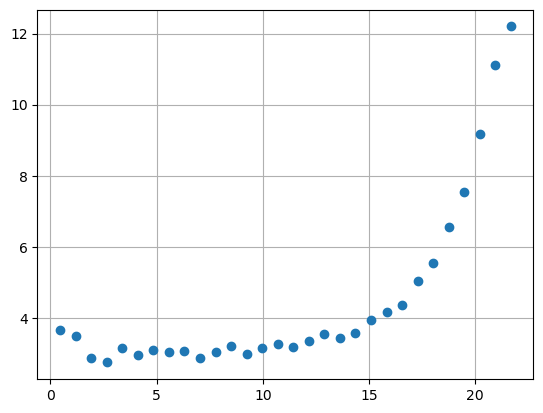

In [79]:
plt.figure()
plt.plot(angs[mask_cov], qcmb_residuals[mask_cov],'.',alpha=0.4)

# xx, yyQ, dx, dyQ, _ = ft.profile(angs[mask_cov], qcmb_residuals[mask_cov], nbins=30, plot=False, dispersion = False)
# plt.figure()
# plt.errorbar(xx,yyQ,yerr=dyQ,fmt='o')
# plt.grid()

# plt.figure()
# plt.errorbar(xx,dyQ,fmt='o')
# plt.grid()

xx, yyQ, dx, dyQ, _ = ft.profile(angs[mask_cov], qcmb_residuals[mask_cov], nbins=30, plot=False, dispersion = True)

plt.figure()
plt.errorbar(xx,dyQ,fmt='o')
plt.grid()

(6, 6, 26381)
62


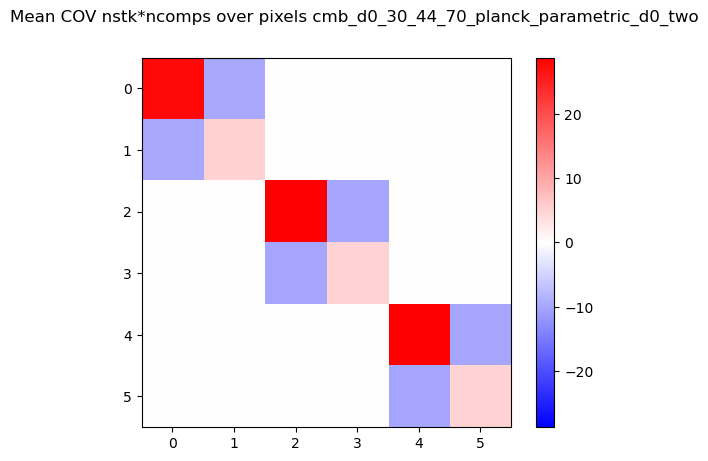

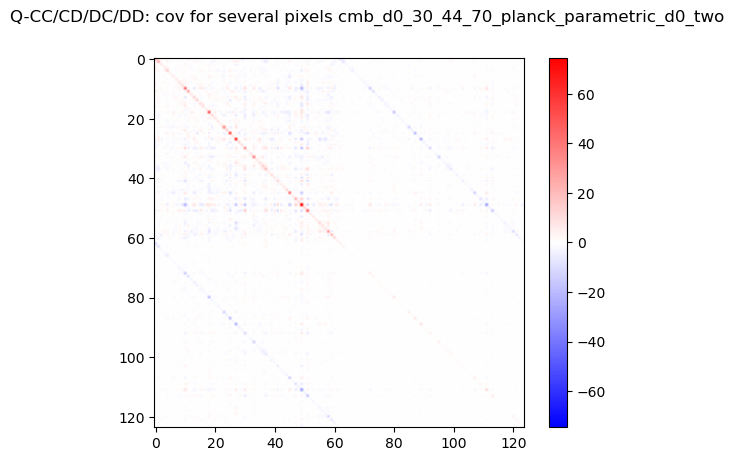

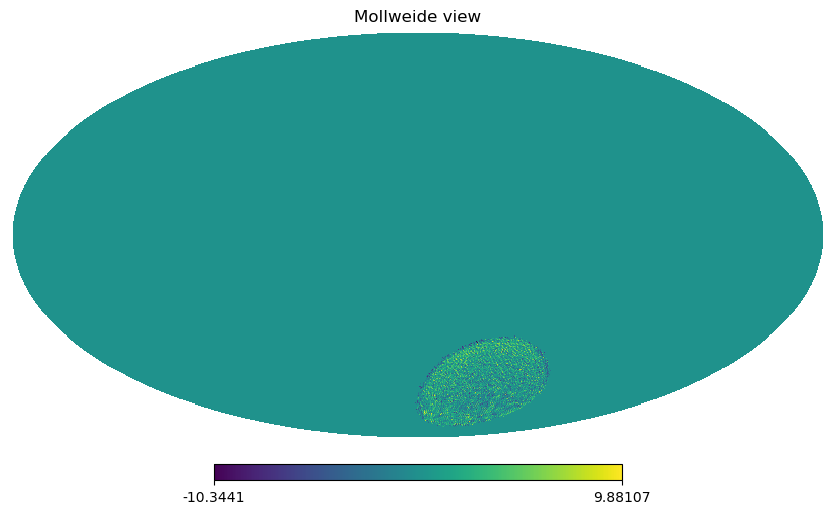

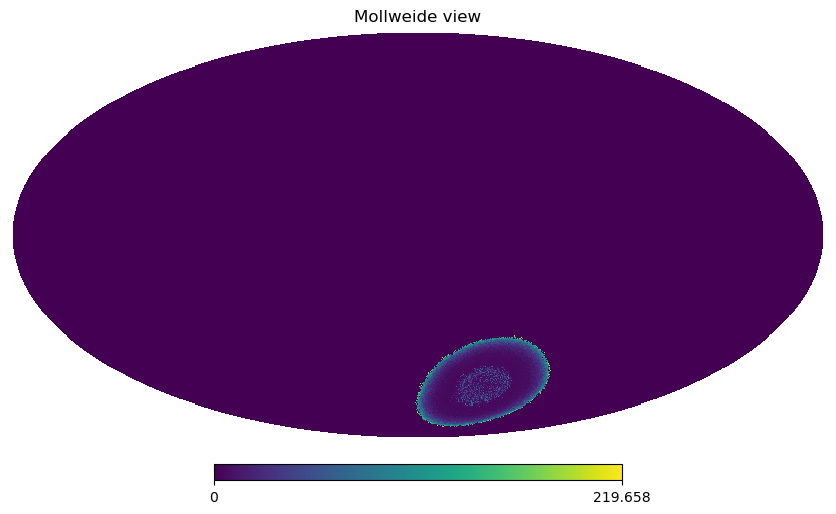

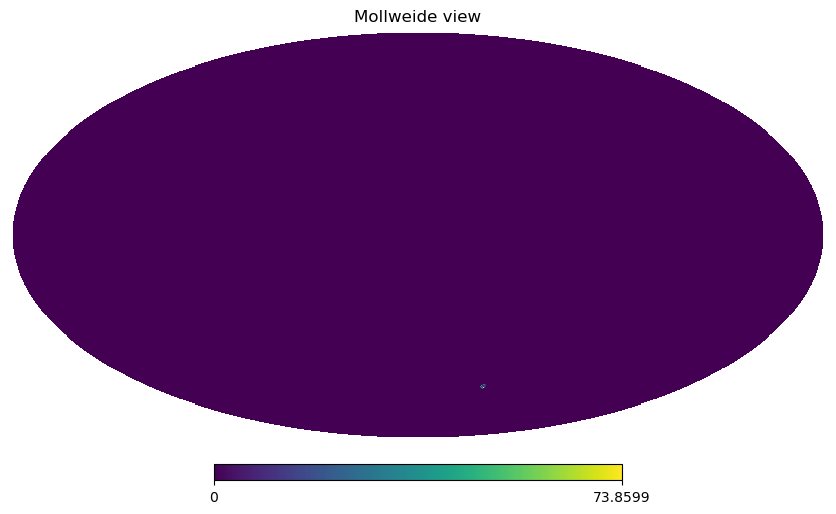

In [140]:
thedir = '/home/nahue-ofi/heavy-data/cmb_d0_30_44_70_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_100_143_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_217_353_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_fullHFI_planck_parametric_d0_two'

# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_30_44_70_planck_parametric_d0_two'
# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_100_143_planck_parametric_d0_two'
# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_217_353_planck_parametric_d0_two'
# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_fullHFI_planck_parametric_d0_two'

realizations = np.sort(glob.glob(thedir+'/'+'**'))

nreals = len(realizations)
 
constant_spectral_index = True

nbins_ring = 35

res = []

for i,map_file in enumerate(realizations):

    comp_out, comp_in, residuals, nside, seenpix, angmax, center = read_maps_from_dict(map_file,constant_spectral_index=constant_spectral_index,nbins_ring=nbins_ring)

    res.append(residuals)

res = np.array(res)

res_qubic = res[:,:,seenpix,:]

cov, corr = amc.get_covcorr_patch(res_qubic,stokesjoint=True)

print(cov.shape)

cov = np.mean(cov[:, :, :],axis=2)
corr = np.mean(corr[:, :, :],axis=2)

plt.figure()

plt.suptitle('Mean COV nstk*ncomps over pixels ' + thedir.split('/')[-1])
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

centralvec = hp.ang2vec(center[0],center[1],lonlat=True)
radius_for_disc = np.deg2rad(1) #input in degree, output in rad
pixs_in_disc = hp.query_disc(nside, centralvec, radius_for_disc)
print(len(pixs_in_disc))

npix_disc = hp.nside2npix(nside)
seenpix_inner_disc = np.zeros(npix_disc)
for i in pixs_in_disc:
    seenpix_inner_disc[i] = 1
seenpix_inner_disc = np.array(seenpix_inner_disc,dtype=bool)

res_inner_qubic = res[:,:,seenpix_inner_disc,:]

cov = np.cov(res_inner_qubic[:,0,:,1],res_inner_qubic[:,1,:,1],rowvar=False)

plt.figure()
plt.suptitle('Q-CC/CD/DC/DD: cov for several pixels '+ thedir.split('/')[-1])
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

npix = hp.nside2npix(nside)
mask = np.zeros(npix)
mask[seenpix] = 1

masked_res = np.zeros((nreals,npix))
for i in range(nreals):
    masked_res[i,:] = mask * res[i,0,:,1]

masked_mean_res = mask*np.mean(res[:,0,:,1],axis=0)

mask_inner = np.zeros(npix)
mask_inner[seenpix_inner_disc] = 1

masked_res_inner = np.zeros((nreals,npix))
for i in range(nreals):
    masked_res_inner[i,:] = mask_inner * res[i,0,:,1]

hp.mollview(masked_mean_res)
hp.mollview(np.std(masked_res,axis=0)**2)
hp.mollview(np.std(masked_res_inner,axis=0)**2)

(6, 6, 26381)
62


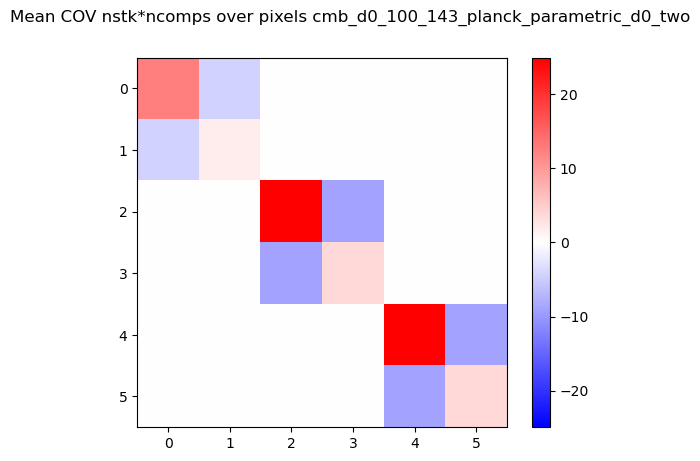

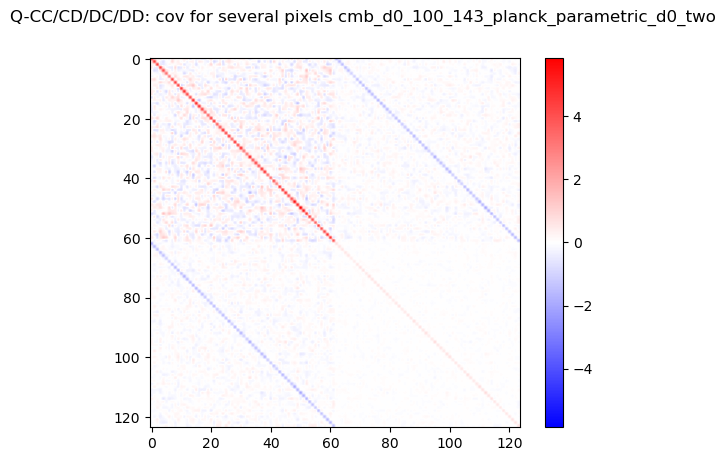

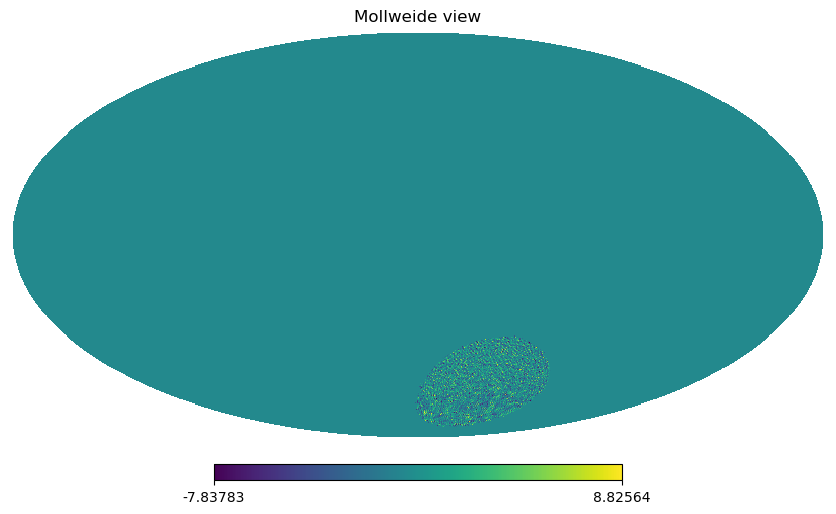

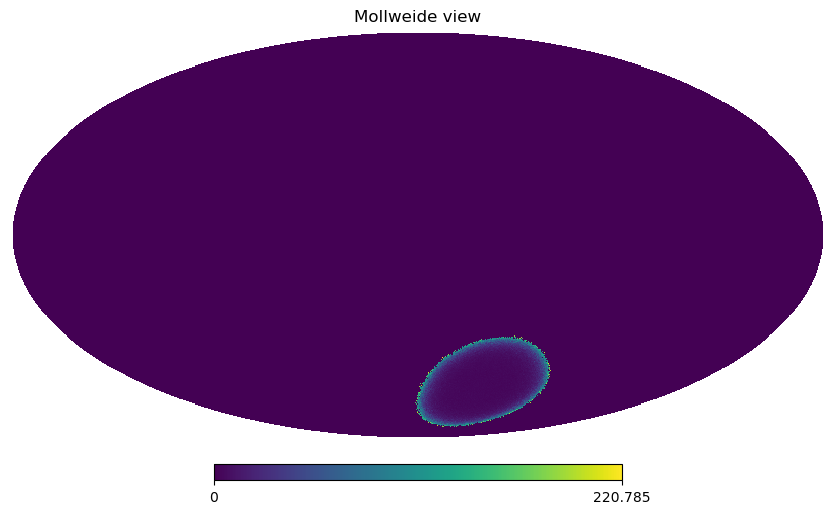

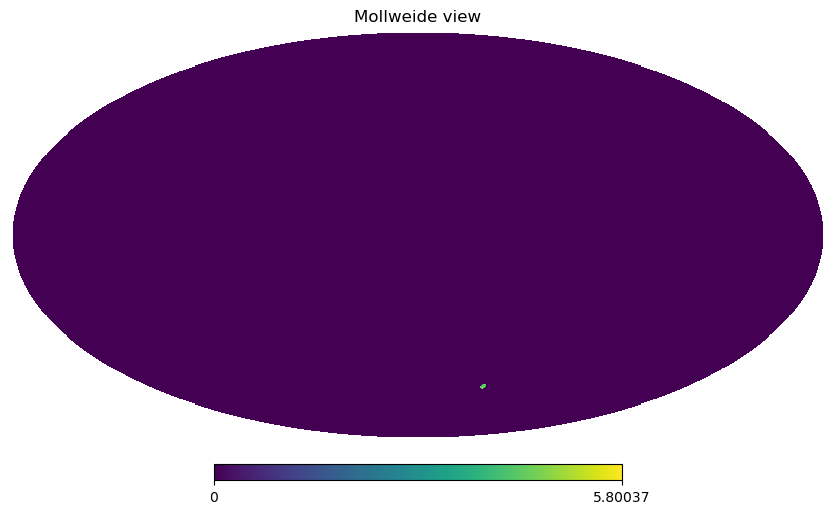

In [141]:
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_30_44_70_planck_parametric_d0_two'
thedir = '/home/nahue-ofi/heavy-data/cmb_d0_100_143_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_217_353_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_fullHFI_planck_parametric_d0_two'

# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_30_44_70_planck_parametric_d0_two'
# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_100_143_planck_parametric_d0_two'
# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_217_353_planck_parametric_d0_two'
# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_fullHFI_planck_parametric_d0_two'

realizations = np.sort(glob.glob(thedir+'/'+'**'))

nreals = len(realizations)
 
constant_spectral_index = True

nbins_ring = 35

res = []

for i,map_file in enumerate(realizations):

    comp_out, comp_in, residuals, nside, seenpix, angmax, center = read_maps_from_dict(map_file,constant_spectral_index=constant_spectral_index,nbins_ring=nbins_ring)

    res.append(residuals)

res = np.array(res)

res_qubic = res[:,:,seenpix,:]

cov, corr = amc.get_covcorr_patch(res_qubic,stokesjoint=True)

print(cov.shape)

cov = np.mean(cov[:, :, :],axis=2)
corr = np.mean(corr[:, :, :],axis=2)

plt.figure()

plt.suptitle('Mean COV nstk*ncomps over pixels ' + thedir.split('/')[-1])
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

centralvec = hp.ang2vec(center[0],center[1],lonlat=True)
radius_for_disc = np.deg2rad(1) #input in degree, output in rad
pixs_in_disc = hp.query_disc(nside, centralvec, radius_for_disc)
print(len(pixs_in_disc))

npix_disc = hp.nside2npix(nside)
seenpix_inner_disc = np.zeros(npix_disc)
for i in pixs_in_disc:
    seenpix_inner_disc[i] = 1
seenpix_inner_disc = np.array(seenpix_inner_disc,dtype=bool)

res_inner_qubic = res[:,:,seenpix_inner_disc,:]

cov = np.cov(res_inner_qubic[:,0,:,1],res_inner_qubic[:,1,:,1],rowvar=False)

plt.figure()
plt.suptitle('Q-CC/CD/DC/DD: cov for several pixels '+ thedir.split('/')[-1])
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

npix = hp.nside2npix(nside)
mask = np.zeros(npix)
mask[seenpix] = 1

masked_res = np.zeros((nreals,npix))
for i in range(nreals):
    masked_res[i,:] = mask * res[i,0,:,1]

masked_mean_res = mask*np.mean(res[:,0,:,1],axis=0)

mask_inner = np.zeros(npix)
mask_inner[seenpix_inner_disc] = 1

masked_res_inner = np.zeros((nreals,npix))
for i in range(nreals):
    masked_res_inner[i,:] = mask_inner * res[i,0,:,1]

hp.mollview(masked_mean_res)
hp.mollview(np.std(masked_res,axis=0)**2)
hp.mollview(np.std(masked_res_inner,axis=0)**2)

/tmp/ipykernel_41685/2709150498.py:12: RuntimeWarning: invalid value encountered in subtract
  residuals = comp_out - comp_in[:ncomps_out,:,:]


(6, 6, 26381)
62


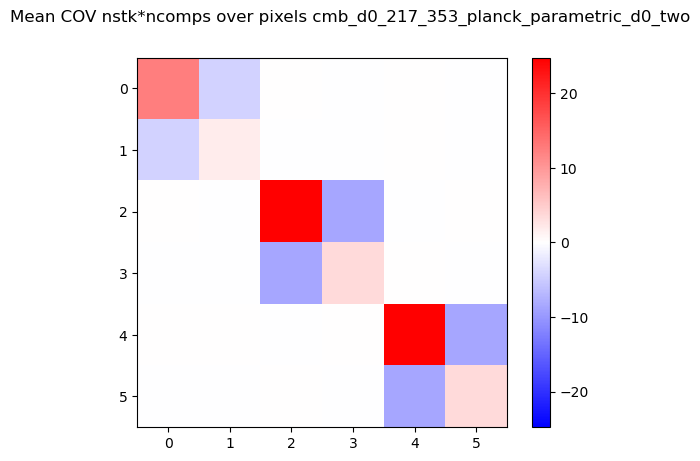

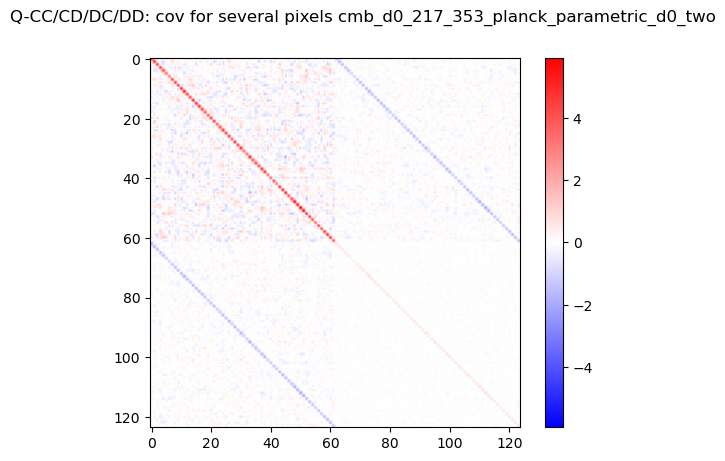

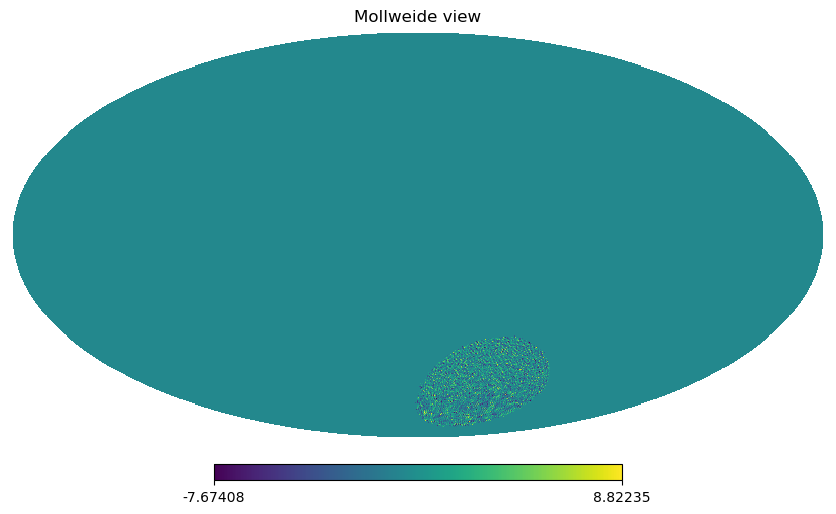

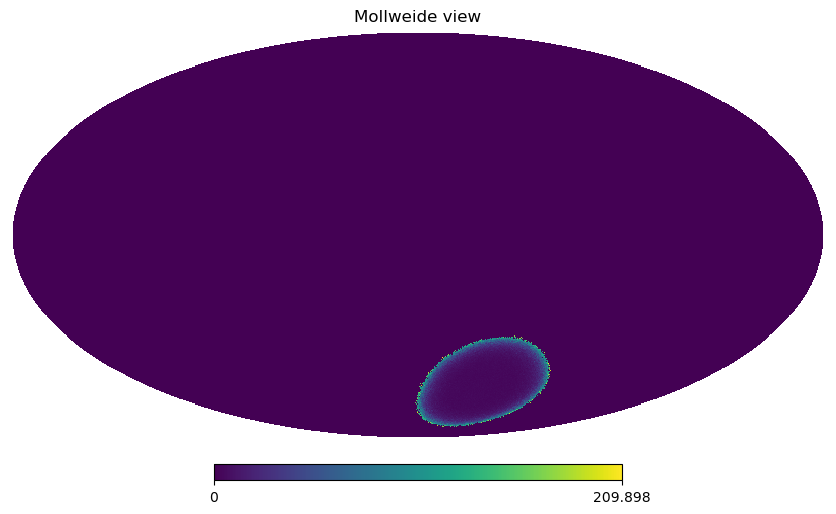

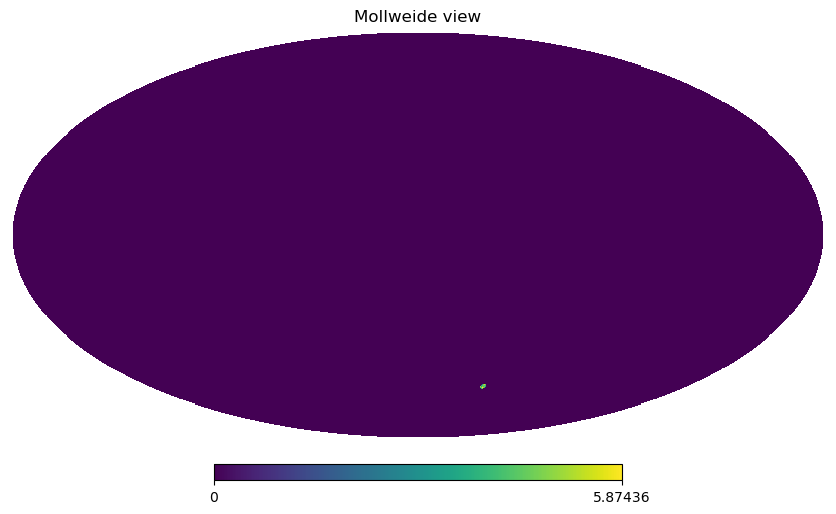

In [142]:
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_30_44_70_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_100_143_planck_parametric_d0_two'
thedir = '/home/nahue-ofi/heavy-data/cmb_d0_217_353_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_fullHFI_planck_parametric_d0_two'

# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_30_44_70_planck_parametric_d0_two'
# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_100_143_planck_parametric_d0_two'
# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_217_353_planck_parametric_d0_two'
# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_fullHFI_planck_parametric_d0_two'

realizations = np.sort(glob.glob(thedir+'/'+'**'))

nreals = len(realizations)
 
constant_spectral_index = True

nbins_ring = 35

res = []

for i,map_file in enumerate(realizations):

    comp_out, comp_in, residuals, nside, seenpix, angmax, center = read_maps_from_dict(map_file,constant_spectral_index=constant_spectral_index,nbins_ring=nbins_ring)

    res.append(residuals)

res = np.array(res)

res_qubic = res[:,:,seenpix,:]

cov, corr = amc.get_covcorr_patch(res_qubic,stokesjoint=True)

print(cov.shape)

cov = np.mean(cov[:, :, :],axis=2)
corr = np.mean(corr[:, :, :],axis=2)

plt.figure()

plt.suptitle('Mean COV nstk*ncomps over pixels ' + thedir.split('/')[-1])
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

centralvec = hp.ang2vec(center[0],center[1],lonlat=True)
radius_for_disc = np.deg2rad(1) #input in degree, output in rad
pixs_in_disc = hp.query_disc(nside, centralvec, radius_for_disc)
print(len(pixs_in_disc))

npix_disc = hp.nside2npix(nside)
seenpix_inner_disc = np.zeros(npix_disc)
for i in pixs_in_disc:
    seenpix_inner_disc[i] = 1
seenpix_inner_disc = np.array(seenpix_inner_disc,dtype=bool)

res_inner_qubic = res[:,:,seenpix_inner_disc,:]

cov = np.cov(res_inner_qubic[:,0,:,1],res_inner_qubic[:,1,:,1],rowvar=False)

plt.figure()
plt.suptitle('Q-CC/CD/DC/DD: cov for several pixels '+ thedir.split('/')[-1])
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

npix = hp.nside2npix(nside)
mask = np.zeros(npix)
mask[seenpix] = 1

masked_res = np.zeros((nreals,npix))
for i in range(nreals):
    masked_res[i,:] = mask * res[i,0,:,1]

masked_mean_res = mask*np.mean(res[:,0,:,1],axis=0)

mask_inner = np.zeros(npix)
mask_inner[seenpix_inner_disc] = 1

masked_res_inner = np.zeros((nreals,npix))
for i in range(nreals):
    masked_res_inner[i,:] = mask_inner * res[i,0,:,1]

hp.mollview(masked_mean_res)
hp.mollview(np.std(masked_res,axis=0)**2)
hp.mollview(np.std(masked_res_inner,axis=0)**2)

(6, 6, 26381)
62


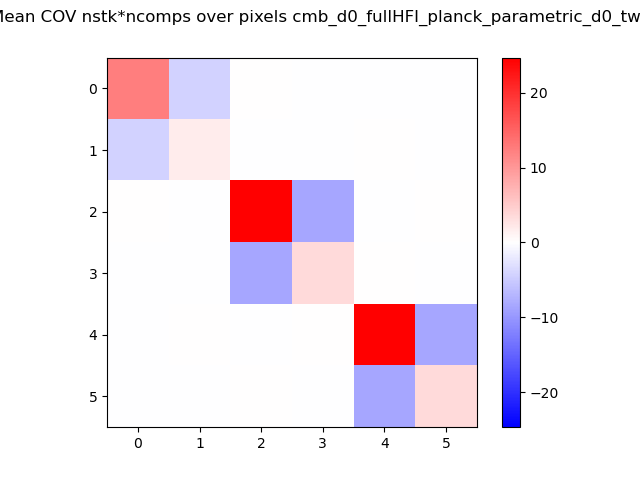

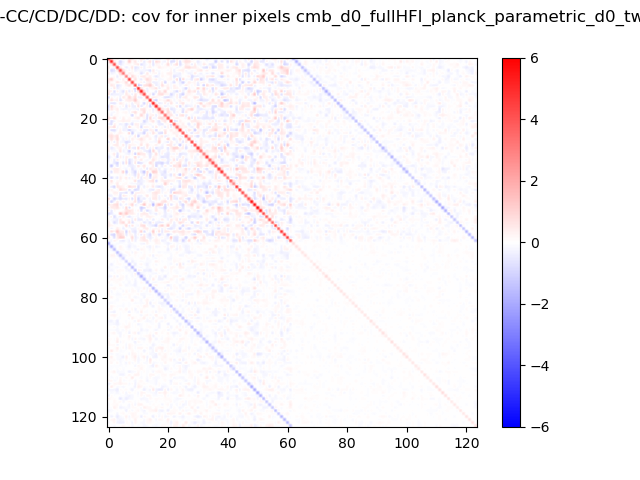

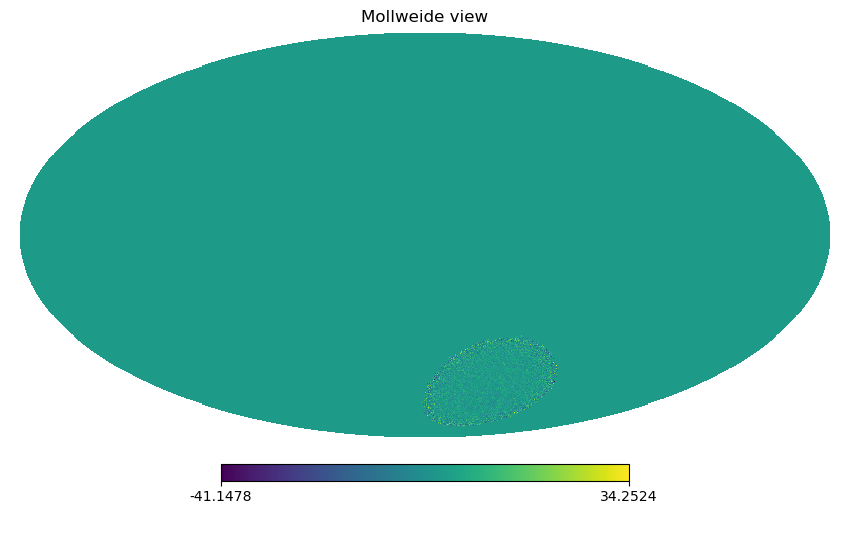

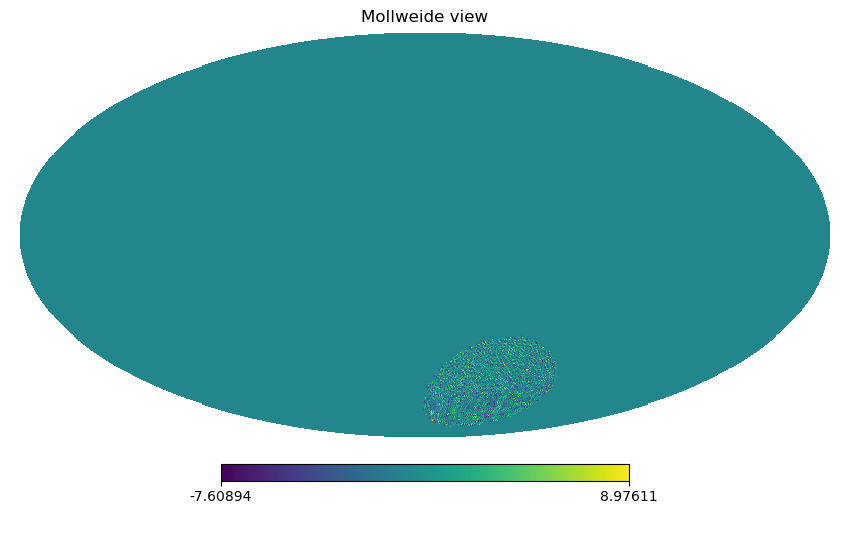

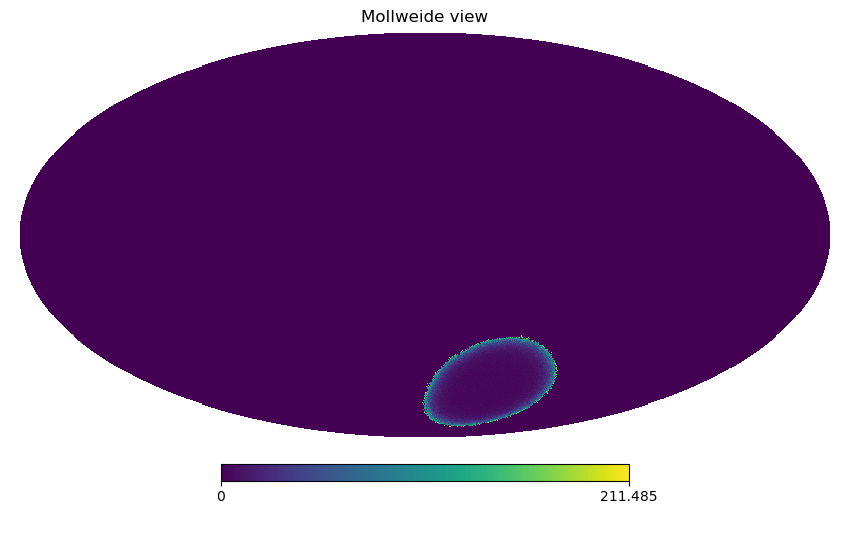

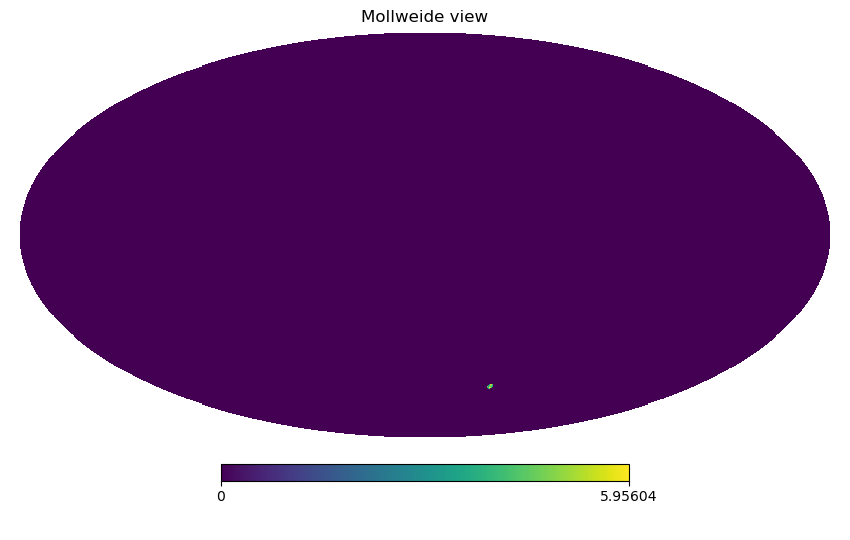

In [125]:
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_30_44_70_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_100_143_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_217_353_planck_parametric_d0_two'
thedir = '/home/nahue-ofi/heavy-data/cmb_d0_fullHFI_planck_parametric_d0_two'

# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_30_44_70_planck_parametric_d0_two'
# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_100_143_planck_parametric_d0_two'
# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_217_353_planck_parametric_d0_two'
# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_fullHFI_planck_parametric_d0_two'

realizations = np.sort(glob.glob(thedir+'/'+'*36*'))

nreals = len(realizations)
 
constant_spectral_index = True

nbins_ring = 35

res = []

for i,map_file in enumerate(realizations):

    comp_out, comp_in, residuals, nside, seenpix, angmax, center, coverage = read_maps_from_dict(map_file,constant_spectral_index=constant_spectral_index,nbins_ring=nbins_ring)

    res.append(residuals)

res = np.array(res)

res_qubic = res[:,:,seenpix,:]

cov, corr = amc.get_covcorr_patch(res_qubic,stokesjoint=True)

print(cov.shape)

cov = np.mean(cov[:, :, :],axis=2)
corr = np.mean(corr[:, :, :],axis=2)

plt.figure()

plt.suptitle('Mean COV nstk*ncomps over pixels ' + thedir.split('/')[-1])
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

centralvec = hp.ang2vec(center[0],center[1],lonlat=True)
radius_for_disc = np.deg2rad(1) #input in degree, output in rad
pixs_in_disc = hp.query_disc(nside, centralvec, radius_for_disc)
print(len(pixs_in_disc))

npix_disc = hp.nside2npix(nside)
seenpix_inner_disc = np.zeros(npix_disc)
for i in pixs_in_disc:
    seenpix_inner_disc[i] = 1
seenpix_inner_disc = np.array(seenpix_inner_disc,dtype=bool)

res_inner_qubic = res[:,:,seenpix_inner_disc,:]

cov = np.cov(res_inner_qubic[:,0,:,1],res_inner_qubic[:,1,:,1],rowvar=False)

plt.figure()
plt.suptitle('Q-CC/CD/DC/DD: cov for inner pixels '+ thedir.split('/')[-1])
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

npix = hp.nside2npix(nside)
mask = np.zeros(npix)
mask[seenpix] = 1

masked_res = np.zeros((nreals,npix))
for i in range(nreals):
    masked_res[i,:] = mask * res[i,0,:,1]

masked_mean_res = mask*np.mean(res[:,0,:,1],axis=0)

mask_inner = np.zeros(npix)
mask_inner[seenpix_inner_disc] = 1

masked_res_inner = np.zeros((nreals,npix))
for i in range(nreals):
    masked_res_inner[i,:] = mask_inner * res[i,0,:,1]

hp.mollview(mask * res[50,0,:,1])
hp.mollview(masked_mean_res)
hp.mollview(np.std(masked_res,axis=0)**2)
hp.mollview(np.std(masked_res_inner,axis=0)**2)

In [4]:
#Downgraded analysis for the full HFI case

nside_out = 32
npix_out = hp.nside2npix(nside_out)
ang_resolution = hp.nside2resol(nside_out, arcmin=True) / 60 # in deg
ratio_pixin_pixout = npix // npix_out

print(f'{ang_resolution} deg')
print(ratio_pixin_pixout)
print(npix_out)

1.8322594196359498 deg
64
12288


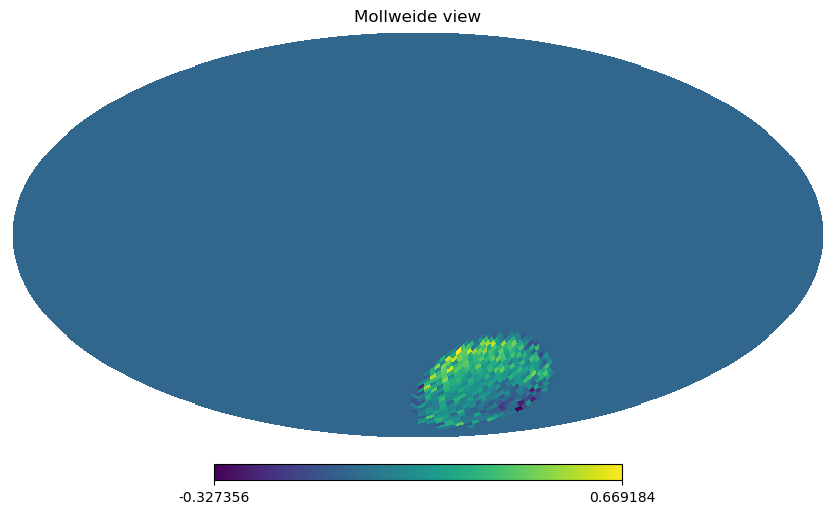

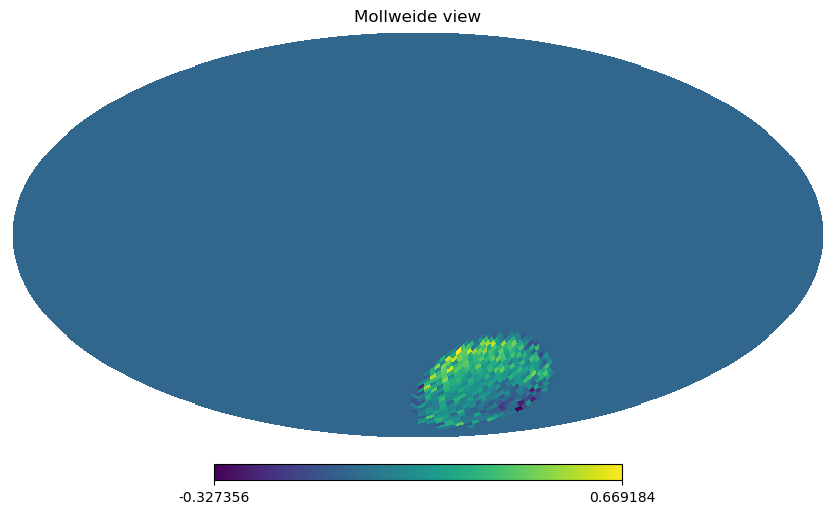

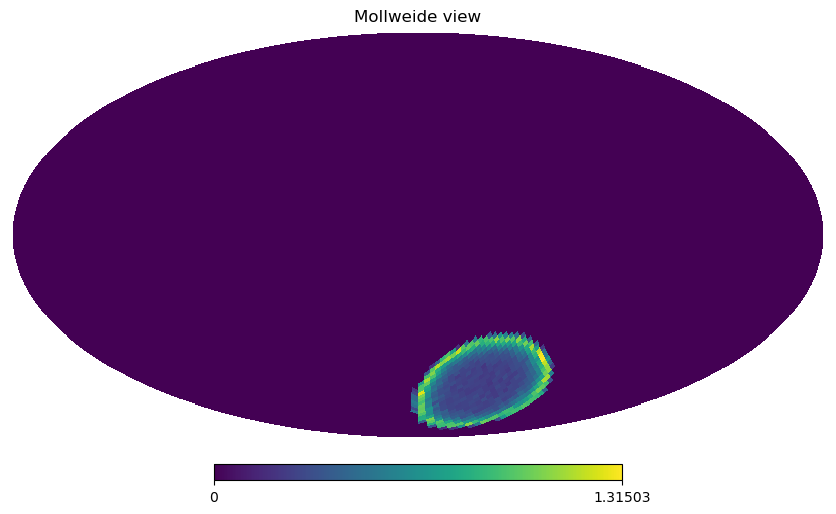

In [8]:
avg_type = 'std'
dispersion = False

res_dg = hp.pixelfunc.ud_grade(masked_res, nside_out)
res_mean_dg = hp.pixelfunc.ud_grade(masked_mean_res, nside_out)
# res_rms_dg = hp.pixelfunc.ud_grade(masked_res, nside_out, avg_type=avg_type, dispersion=dispersion)

hp.mollview(np.mean(res_dg,axis=0))
hp.mollview(res_mean_dg)

hp.mollview(np.std(res_dg,axis=0))
# hp.mollview(np.mean(res_rms_dg,axis=0))

(99, 469)


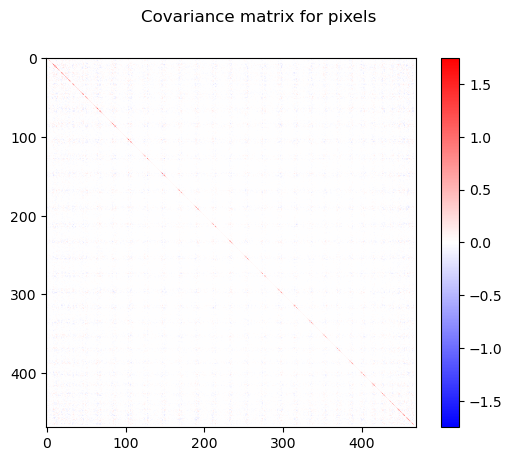

In [9]:
mask_dg = hp.pixelfunc.ud_grade(mask, nside_out)
seenpix_dg = np.array(mask_dg,dtype=bool)

res_dg_qubic = res_dg[:,seenpix_dg]
print(np.shape(res_dg_qubic))

cov = np.cov( res_dg_qubic, rowvar = False )
plt.figure()
plt.suptitle('Covariance matrix for pixels')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

In [10]:
cov = np.cov( res_dg, rowvar = False )
cov = cov[seenpix_dg,:]
cov = cov[:,seenpix_dg]
print(np.shape(cov))

(469, 469)


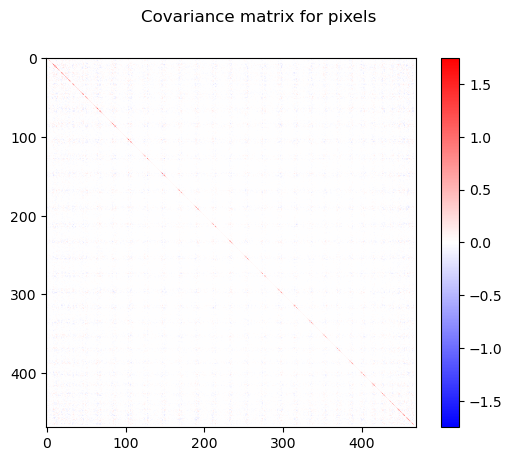

In [11]:
plt.figure()
plt.suptitle('Covariance matrix for pixels')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

(99, 2, 786432, 3)
(99, 2, 26381, 3)
(6, 6, 26381)


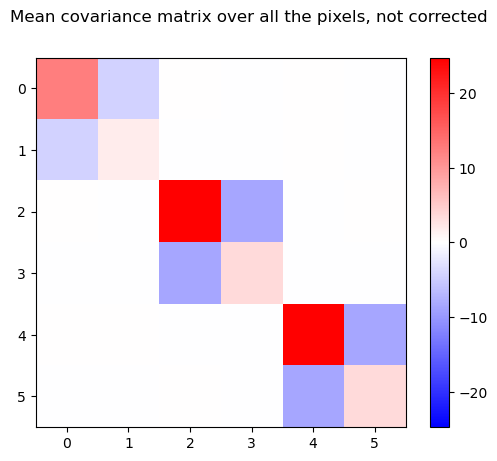

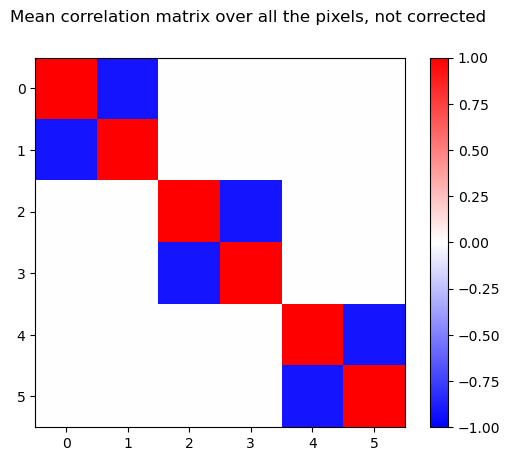

In [12]:
res_qubic = res[:,:,seenpix,:]
print(res.shape)
print(res_qubic.shape)

cov, corr = amc.get_covcorr_patch(res_qubic,stokesjoint=True)
print(cov.shape)
meancov_notcorrected = np.mean(cov[:, :, :],axis=2)
meancorr_notcorrected = np.mean(corr[:, :, :],axis=2)

plt.figure()
plt.suptitle('Mean covariance matrix over all the pixels, not corrected')
vmax = np.max(np.abs(meancov_notcorrected[:, :]))
plt.imshow(meancov_notcorrected[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()
plt.figure()
plt.suptitle('Mean correlation matrix over all the pixels, not corrected')
vmax = np.max(np.abs(meancorr_notcorrected[:, :]))
plt.imshow(meancorr_notcorrected[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

# meancov_corrected = np.mean(cov[:, :, :],axis=2)
# meancorr_corrected = np.mean(corr[:, :, :],axis=2)

# for i in range(res_qubic.shape[0]):
#     covqcc_pix[i] = np.sum(cov[0, 0, :])
# np.sum(cov[1, 1, :])
# np.sum(cov[, 0, :])
# np.sum(cov[0, 0, :])
# np.sum(cov[0, 0, :])
# np.trace(cov)

# plt.figure()
# plt.suptitle('Mean covariance matrix over all the pixels, corrected')
# vmax = np.max(np.abs(meancov_corrected[:, :]))
# plt.imshow(meancov_corrected[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
# plt.colorbar()
# plt.figure()
# plt.suptitle('Mean correlation matrix over all the pixels, corrected')
# vmax = np.max(np.abs(meancorr_corrected[:, :]))
# plt.imshow(meancorr_corrected[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
# plt.colorbar()

In [10]:
# cov = np.cov( Q_cmb, rowvar = False )
# plt.figure()
# plt.suptitle('Q CMB: covariance matrix of the residuals for angular rings')
# vmax = np.max(np.abs(cov[:, :]))
# plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
# plt.colorbar()

# cov = np.cov( dQ_cmb, rowvar = False )
# plt.figure()
# plt.suptitle('Q CMB: covariance matrix of the residuals RMS for angular rings')
# vmax = np.max(np.abs(cov[:, :]))
# plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
# plt.colorbar()

# cov = np.cov( Q_dust, rowvar = False )
# plt.figure()
# plt.suptitle('Q Dust: covariance matrix of the residuals for angular rings')
# vmax = np.max(np.abs(cov[:, :]))
# plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
# plt.colorbar()

# cov = np.cov( dQ_dust, rowvar = False )
# plt.figure()
# plt.suptitle('Q Dust: covariance matrix of the residuals RMS for angular rings')
# vmax = np.max(np.abs(cov[:, :]))
# plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
# plt.colorbar()

In [11]:
# cov = np.cov( U_cmb, rowvar = False )
# plt.figure()
# plt.suptitle('U CMB: covariance matrix of the residuals for angular rings')
# vmax = np.max(np.abs(cov[:, :]))
# plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
# plt.colorbar()

# cov = np.cov( dU_cmb, rowvar = False )
# plt.figure()
# plt.suptitle('U CMB: covariance matrix of the residuals RMS for angular rings')
# vmax = np.max(np.abs(cov[:, :]))
# plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
# plt.colorbar()

# cov = np.cov( U_dust, rowvar = False )
# plt.figure()
# plt.suptitle('U Dust: covariance matrix of the residuals for angular rings')
# vmax = np.max(np.abs(cov[:, :]))
# plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
# plt.colorbar()

# cov = np.cov( dU_dust, rowvar = False )
# plt.figure()
# plt.suptitle('U Dust: covariance matrix of the residuals RMS for angular rings')
# vmax = np.max(np.abs(cov[:, :]))
# plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
# plt.colorbar()

In [12]:
# res_qubic = res[:,:,seenpix,:]
# print(res.shape)
# print(res_qubic.shape)

In [13]:
pixels = np.arange(res_dg.shape[1])[seenpix_dg]
# pixels = np.arange(res.shape[2])[seenpix]
# print(pixels)
print(len(pixels))

469


In [21]:
# twopt_matrix_qcmb = np.empty((2,int((len(pixels)**2+len(pixels))/2)))
twopt_matrix_qcmb = np.empty((2,len(pixels),len(pixels)))
twopt_matrix_qcmb[:] = np.nan

realp = 98
meanval_realp = np.mean(res_dg[realp,:])

for i,pixel_i in enumerate(pixels):
    for j,pixel_j in enumerate(pixels):
        if j>=i:
            twopt_matrix_qcmb[0,i,j] = (res_dg[realp,pixel_i]-meanval_realp)*(res_dg[realp,pixel_j]-meanval_realp)
            # twopt_matrix_qcmb[0,i,j] = res_mean_dg[pixel_i]*res_mean_dg[pixel_j]
            # twopt_matrix_qcmb[0,i,j] = (res_mean_dg[pixel_i]-np.mean(res_mean_dg[:]))*(res_mean_dg[pixel_j]-np.mean(res_mean_dg[:]))
            # twopt_matrix_qcmb[0,i,j] = res_rms_dg[0,pixel_i]*res_rms_dg[0,pixel_j]
            # twopt_matrix_qcmb[0,i,j] = res[0,0,pixel_i,1]*res[0,0,pixel_j,1]
            twopt_matrix_qcmb[1,i,j] = np.degrees(np.arccos(np.dot(hp.pix2vec(nside_out,pixel_i), hp.pix2vec(nside_out,pixel_j))))
            # twopt_matrix_qcmb[1,i,j] = np.degrees(np.arccos(np.dot(hp.pix2vec(nside,pixel_i), hp.pix2vec(nside,pixel_j))))

/tmp/ipykernel_5429/2771649663.py:16: RuntimeWarning: invalid value encountered in arccos
  twopt_matrix_qcmb[1,i,j] = np.degrees(np.arccos(np.dot(hp.pix2vec(nside_out,pixel_i), hp.pix2vec(nside_out,pixel_j))))


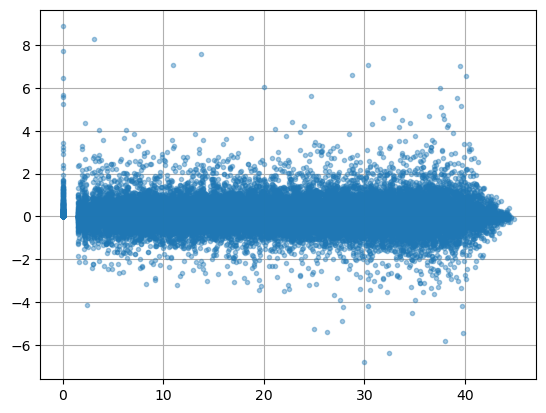

In [22]:
# print(twopt_matrix_qcmb[0,:,:])
qcmb2 = np.ravel(twopt_matrix_qcmb[0,:,:])
angles = np.ravel(twopt_matrix_qcmb[1,:,:])
ok =  (~np.isnan(qcmb2) * ~np.isnan(angles))
# print(ok)
qcmb2 = qcmb2[ok]
angles = angles[ok]

plt.figure()
plt.plot(angles,qcmb2,'.',alpha=0.4)
plt.grid(which='both')

# angmax_2pt = np.max(angles)

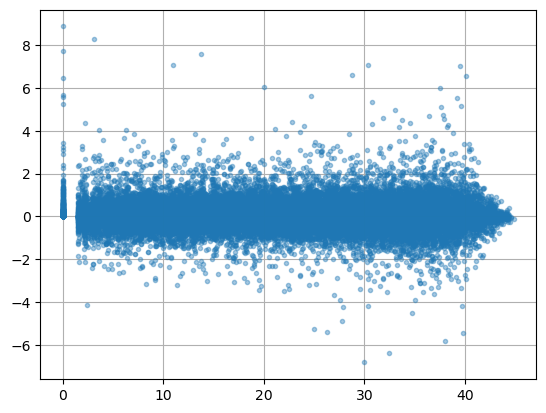

In [23]:
ind_sorted = np.argsort(angles)
angles = np.take_along_axis(angles,ind_sorted,axis=0)
qcmb2 = np.take_along_axis(qcmb2,ind_sorted,axis=0)

# plt.figure()
# plt.plot(angles)

# plt.figure()
# plt.plot(qcmb2)

plt.figure()
plt.plot(angles,qcmb2,'.',alpha=0.4)
plt.grid(which='both')

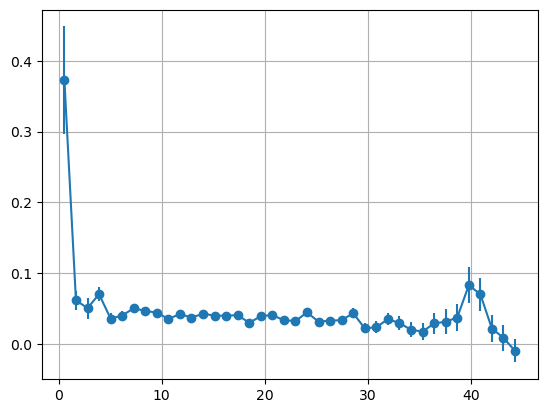

In [30]:
nbins=40

theta_center, mean_corr, dtheta, dmean, others = ft.profile(angles,qcmb2,nbins=nbins,dispersion=False,plot=False)

plt.figure()
plt.errorbar(theta_center,mean_corr,yerr=dmean,xerr=dtheta,fmt='o-')

# plt.yscale('log')
plt.grid()

In [43]:
# fastsimulatormethod

# th, cth_qn, err_qn = qss.ctheta_parts(res)

print(diff.shape)

(786432, 3)


3.6560255109909194


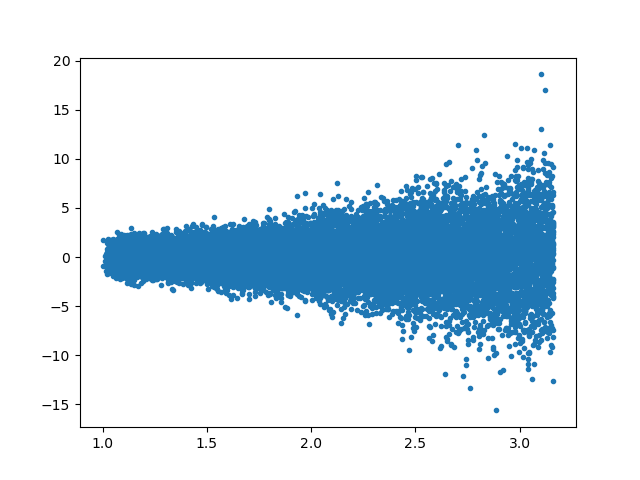

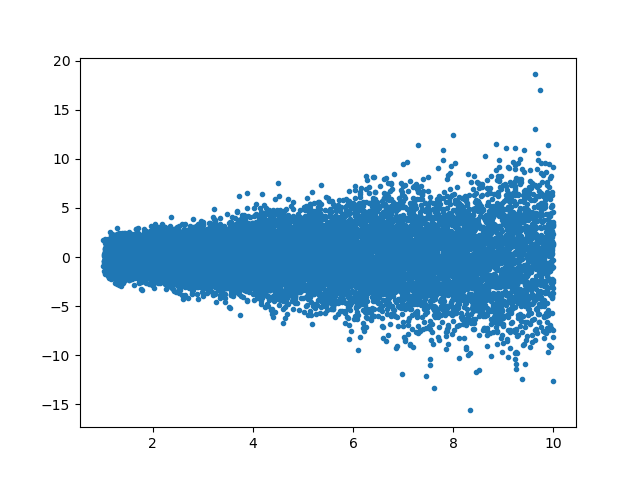

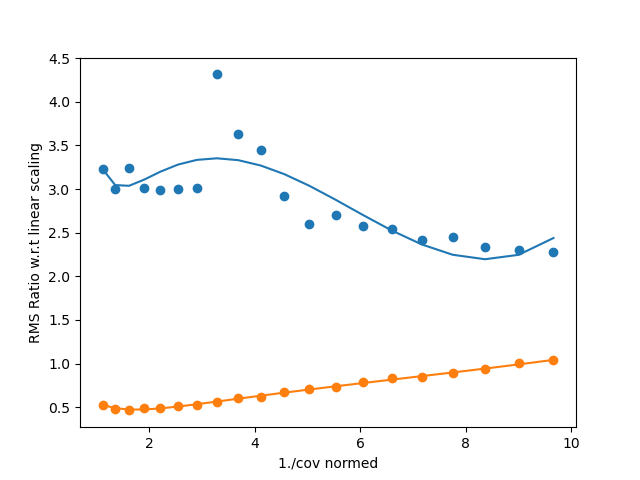

In [105]:
# diff is a residuals map
okpix = coverage/np.max(coverage) > covcut 

plt.figure()
plt.plot(np.sqrt(np.max(coverage)/coverage[okpix]),diff[okpix,1],'.')
plt.figure()
plt.plot(np.max(coverage)/coverage[okpix],diff[okpix,1],'.')
print(np.std(diff[okpix,1])**2)
######### Fitting noise profile again
plt.figure()
diff = res[0,1,:,:]
nbins = 20
xx, yy, fit_n200k = qss.get_noise_invcov_profile(diff, coverage, nbins=nbins, QUsep=True,
                                              label='NERSC 200000',fit=True,doplot=True)

1.9996623585839517


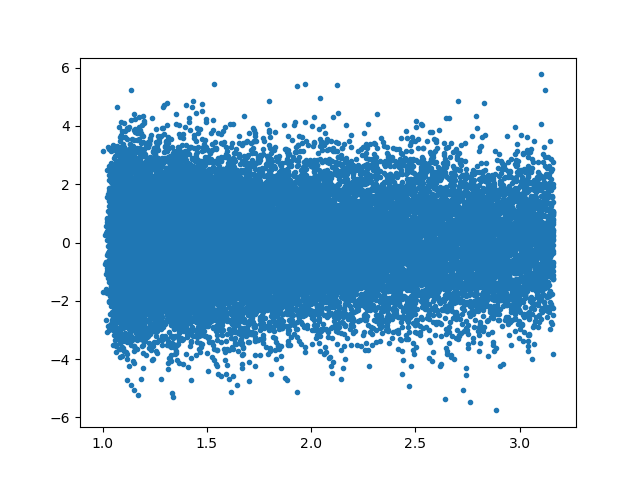

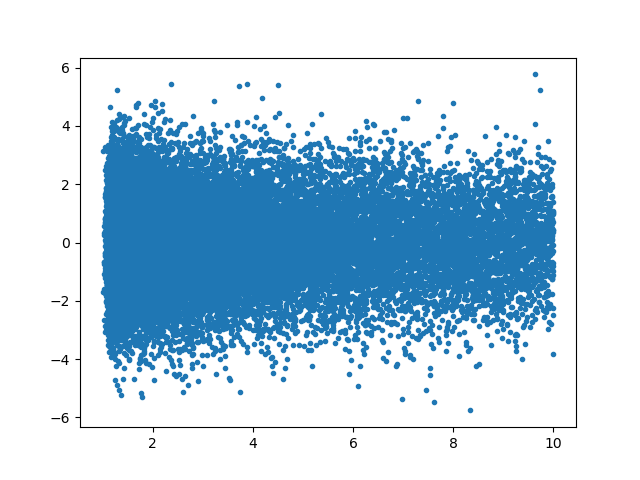

In [107]:
######### Flattening maps
new_diff = qss.correct_maps_rms(diff, coverage, fit_n200k)

plt.figure()
plt.plot(np.sqrt(np.max(coverage)/coverage[okpix]),new_diff[okpix,1],'.')

plt.figure()
plt.plot(np.max(coverage)/coverage[okpix],new_diff[okpix,1],'.')

print(np.std(new_diff[okpix,1])**2)

0.2374930331559285

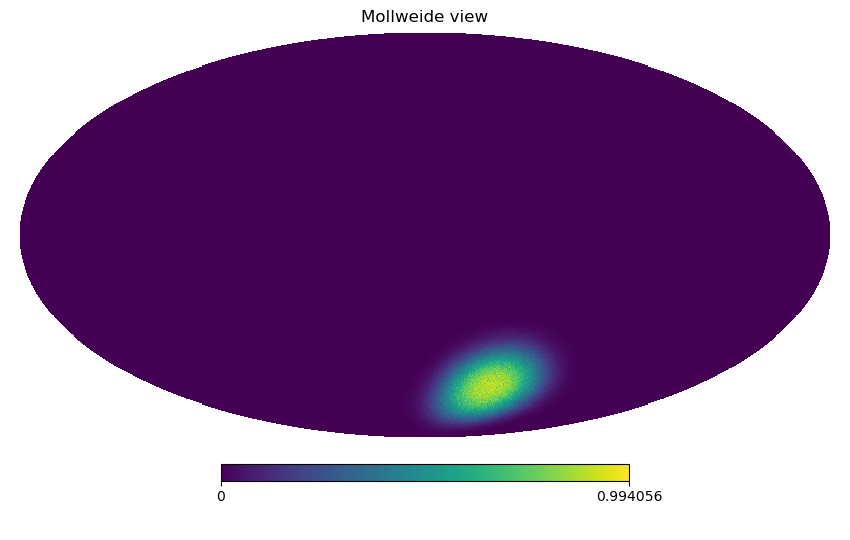

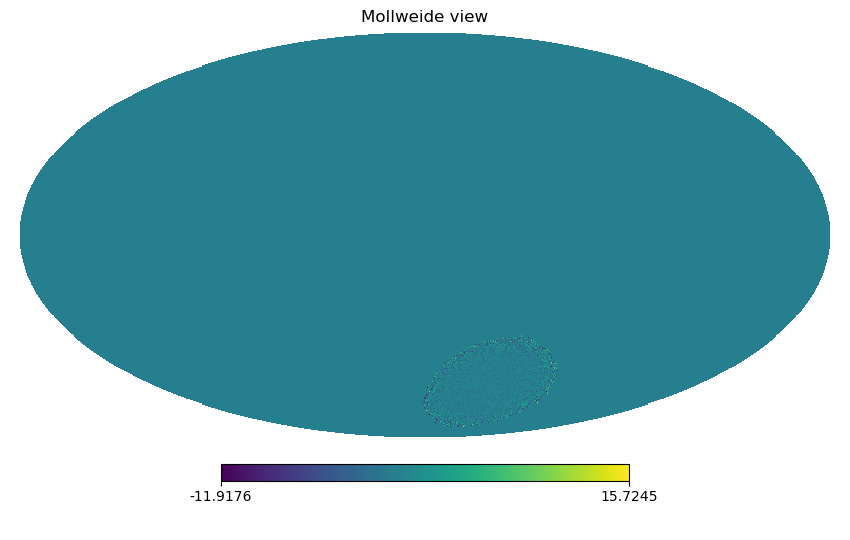

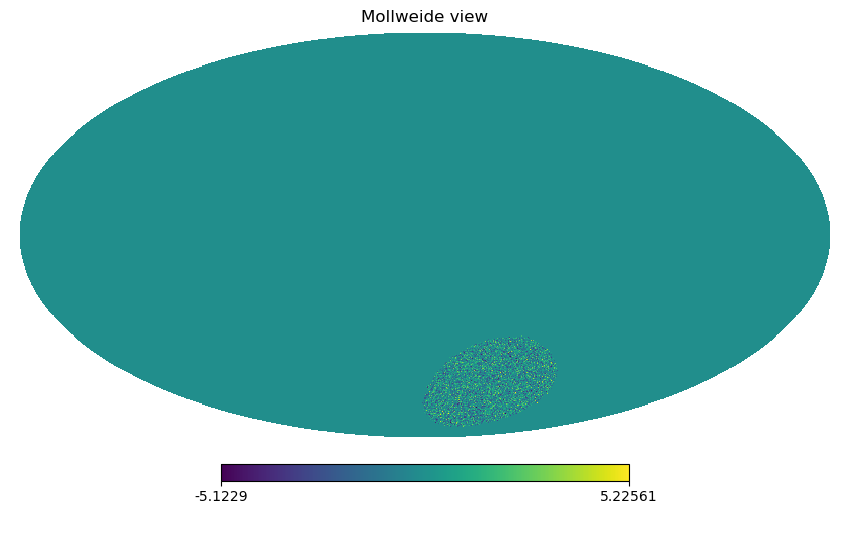

In [123]:
diff = res[70,1,:,:]

out_map,_ = qss.flatten_noise(diff,coverage)

mask = coverage/np.max(coverage) > 0.1

diff_qmasked = diff[:,1]
diff_qmasked[~mask] = 0
out_map_qmasked = out_map[:,1]
out_map_qmasked[~mask] = 0

hp.mollview(coverage/np.max(coverage))
hp.mollview(diff_qmasked)
hp.mollview(out_map_qmasked)
np.std(out_map)

In [134]:
############ Calculating C(theta)
ns = 256
okpix = coverage > (np.max(coverage)*0.1)
ip = np.arange(12*ns**2).astype(int)
ipok = ip[okpix]

th, cth_200k, err_200k = qss.ctheta_parts(new_diff[:,0], ipok, 0, 20, 50, nsplit=2, verbose=False, degrade_init=128)

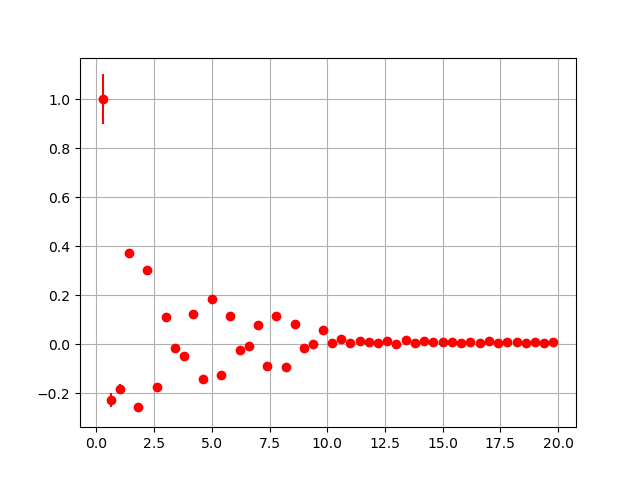

In [135]:
%matplotlib ipympl
plt.figure()
plt.errorbar(th, cth_200k/np.max(cth_200k),fmt='ro')#, yerr=err_200k
plt.grid()

In [ ]:
th, cth_200k, err_200k = qss.ctheta_parts(diff[:,0], ipok, 0, 20, 20, nsplit=4, verbose=False)#, degrade_init=128
%matplotlib ipympl

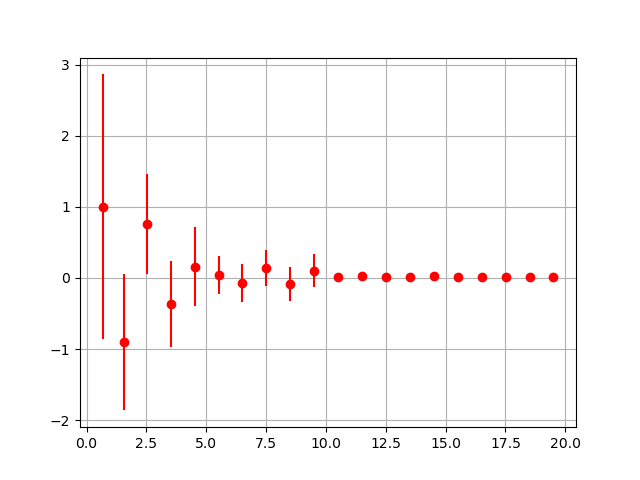

In [128]:
plt.figure()
plt.errorbar(th, cth_200k/np.max(cth_200k),fmt='ro') #, yerr=err_200k
plt.grid()